In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
import scipy

#### General Functions

In [2]:
def Adapt_function(Stim_value, alpha, x0, b):
    v_ = alpha*(0.5*(np.tanh(Stim_value - x0) + 1)  - b)
    v_ = np.where(v_<0, 0, v_)
    return v_

In [3]:
def Prob(x, sigma, s0):
    return 1/(np.sqrt(2*np.pi*sigma**2))*np.exp( -(x - s0)**2/(2*sigma**2) )

### Population of ORNs for thre three different types of adaptation

#### Parameters

In [4]:
## ----- Population parameters --------
N = 150  # Number of neurons in the population
s_array =  np.arange(-5, 6,0.1) # Stimulus array
Amp = 100  # Response amplitude
np.random.seed(2010) #Set random seed

alpha = 100
lambda_p = 0.001
dist = np.cumsum((1/lambda_p)*np.log(1/np.random.uniform(low = 0, high = 1, size = N)))
#dist = (1/lambda_p)*np.log(1/np.random.uniform(low = 0, high = 1, size = N))
norm = np.max(dist) 
ran_array = dist/norm
x0_array = -4 + 6*ran_array
#x0_array = -4 + 6*np.random.rand(N, 1) # Shift parameter for each neuron in the population
alpha_array = np.ones(N)
b_array = np.zeros(N)
th = 0.2   # Threshold response at which the neuron adapts

string = ['shift_x', 'compression', 'shift_y']
par_case = 2 # 0 for shift, 1 for compression and 2 for y-shift

shift_x


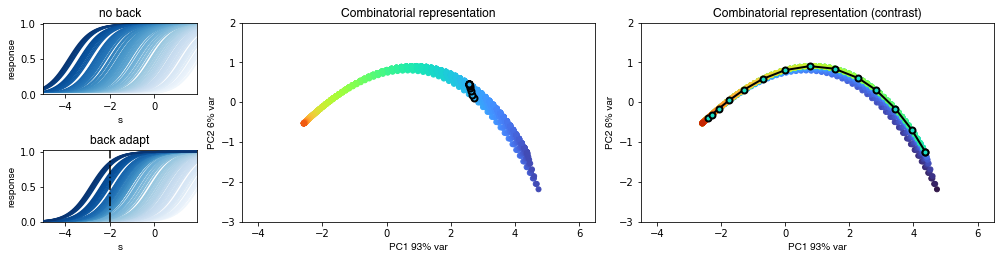

compression


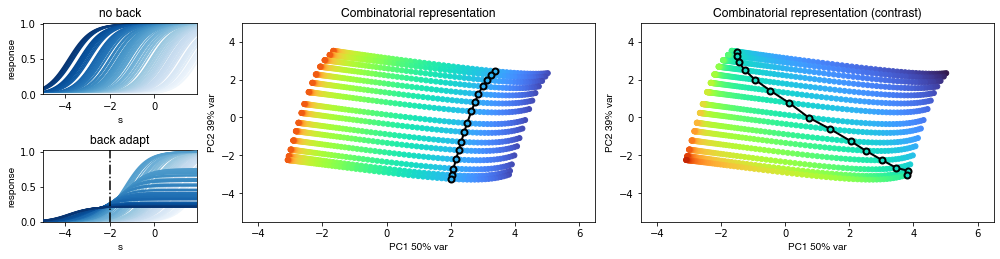

shift_y


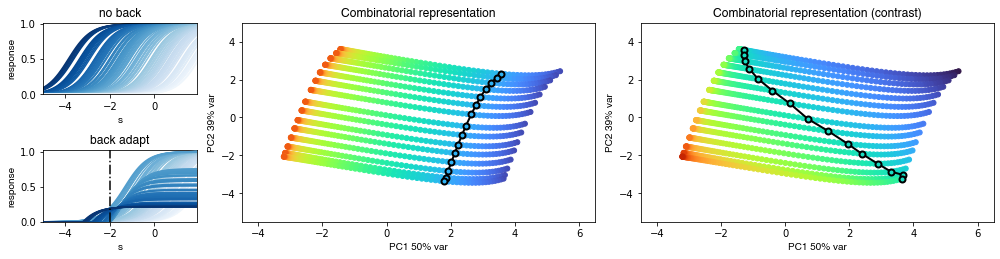

In [12]:
font = {'family': 'helvetica'}
plt.rcParams['pdf.fonttype'] = 'truetype'
color_map_neurons = plt.cm.Blues_r
color_map_pca = plt.cm.turbo#nipy_spectral
norm = Normalize(vmin=0, vmax=5)
norm_contrast = Normalize(vmin=0, vmax=1)
for par_case in np.array([0, 1, 2]):
    print(string[par_case])
    ## ----- Figure parameters ------
#     color_map = plt.cm.jet
    plt.figure(figsize=(14, 3.7))
    gs = gridspec.GridSpec(2, 5)  # 2 rows, 5 columns grid
    ax1 = plt.subplot(gs[0, 0])  # This subplot spans the first column of the first row
    ax2 = plt.subplot(gs[1, 0])  # This subplot spans the first column of the second row
    ax3 = plt.subplot(gs[:, 1:3])  # This spans all rows and the last two columns
    ax4 = plt.subplot(gs[:, 3:])  # This spans all rows and the last two columns
    ax1.set_title('no back', fontdict=font)
    ax1.set_xlabel('s', fontdict=font)
    ax1.set_ylabel('response', fontdict=font)
    ax1.set_xlim([-5, 1.9])
    ax1.set_ylim([0, 1.02])
    ax2.set_title('back adapt', fontdict=font)
    ax2.set_xlabel('s', fontdict=font)
    ax2.set_ylabel('response', fontdict=font)
    ax2.set_xlim([-5, 1.9])
    ax2.set_ylim([0, 1.02])
    ax3.set_title('Combinatorial representation', fontdict=font)
    ax4.set_title('Combinatorial representation (contrast)', fontdict=font)

    ci_0 = 4
    module_par = 8
    
    
    for i_N in range(N):
        r = Adapt_function(s_array, np.sort(alpha_array)[i_N], np.sort(x0_array)[i_N], np.sort(b_array)[i_N]) # Response with non-adapted parameters
        ci = ci_0 + x0_array[i_N]
        ax1.plot(s_array, r, color=color_map_neurons(0.8*norm(ci % module_par)))
    
    ## ----- Background adaptation ----
    s_back = -3  # Value of the background stimulus. Original stimuli range from [-5 to 2]
    th = 0.3   # Threshold response at which the neuron adapts
    x0_array_a = np.copy(x0_array)
    alpha_array_a = np.copy(alpha_array)
    b_array_a = np.copy(b_array)

    dx_back = 0.2
    Back_array = -np.arange(0.6, 3.5, dx_back)
    N_back = Back_array.size
    N_t = 80
    test_array = np.linspace(-0.5, 4, num=N_t)
    r_test = np.zeros((N_back*N_t + N_t, N))
    r_test_norm = np.zeros((N_back*N_t + N_t, N))
    r_b_array = np.zeros((s_array.size, N))
    alpha_norm = np.ones(N)
    
    for i_back in range(N_back):
        x0_array_a = np.copy(x0_array)
        alpha_array_a = np.copy(alpha_array)
        b_array_a = np.copy(b_array)
        s_back = Back_array[i_back]
        for i_N in range(N):
            r_b = Adapt_function(s_back, alpha_array[i_N], x0_array[i_N], b_array[i_N])
            if r_b > th:
                if par_case == 0: 
                    x0_array_a[i_N] += r_b
                if par_case == 1:
                    alpha_array_a[i_N] = 1 - 0.8*r_b
                if par_case == 2:
                    b_array_a[i_N] = 0.8*r_b
                    
            r_adapt = Adapt_function(s_array, alpha_array_a[i_N], x0_array_a[i_N], b_array_a[i_N])
            r_b_array[:, i_N] = np.copy(r_adapt)
               
                
        for i_t in range(N_t):
            link_neurons = np.arange(N)
            r_test[i_t, :] = Adapt_function(test_array[i_t], alpha_array.flatten(), x0_array.flatten(), b_array.flatten())
            r_test[(i_back+1)*N_t + i_t, :]= Adapt_function(test_array[i_t], alpha_array_a.flatten(), x0_array_a.flatten(), b_array_a.flatten())
            r_test_norm[i_t, :] = r_test[i_t, :]/(1 + r_test[i_t, :] + alpha_norm[link_neurons]*np.mean(r_test[i_t, link_neurons]))
            r_test_norm[(i_back+1)*N_t + i_t, :]= r_test[(i_back+1)*N_t + i_t, :]/(1 + r_test[(i_back+1)*N_t + i_t, :] + alpha_norm[link_neurons]*np.mean(r_test[(i_back+1)*N_t + i_t, link_neurons]))

        if norm_par == 1:  
            ax3.set_xlim([-1.5, 1.5])
            ax3.set_ylim([-1.5, 1.5])
            ax4.set_xlim([-1.5, 1.5])
            ax4.set_ylim([-1.5, 1.5])
            r_test = r_test_norm
            if s_back == -2:
                ax2.axvline(x=-2, color = 'k', linestyle = '-.', zorder = 1000)
                for i_N in range(N):
                    link_neurons = np.arange(N)
                    r_a =  Adapt_function(s_array,alpha_array_a[i_N], x0_array_a[i_N], b_array_a[i_N])/(1 + Adapt_function(s_array,alpha_array_a[i_N], x0_array_a[i_N], b_array_a[i_N]) + alpha_norm[i_N]*np.mean(r_b_array[:,link_neurons], axis = 1))
                    ci = ci_0 + x0_array[i_N]
                    ax2.plot(s_array, r_a/0.5, color=color_map_neurons(0.8*norm(ci % module_par)), zorder = 100 - x0_array[i_N])

        else:
            ax3.set_xlim([-4.5, 6.5])
            ax3.set_ylim([-5.5, 5.])
            ax4.set_xlim([-4.5, 6.5])
            ax4.set_ylim([-5.5, 5])
            if par_case==0:
                ax3.set_xlim([-4.5, 6.5])
                ax3.set_ylim([-3, 2.])
                ax4.set_xlim([-4.5, 6.5])
                ax4.set_ylim([-3, 2])
            if np.logical_and(s_back >= -2, s_back < -2 + dx_back):
                ax2.axvline(x=-2, color = 'k', linestyle = '-.', zorder = 1000)
                for i_N in range(N):
                    r_a = Adapt_function(s_array,alpha_array_a[i_N], x0_array_a[i_N], b_array_a[i_N])
                    ci = ci_0 + x0_array[i_N]#+ int(np.round(x0_array[i_N]))
                    ax2.plot(s_array, r_a, color=color_map_neurons(0.8*norm(ci % module_par)), zorder = 100 - x0_array[i_N]) 

    pca = PCA(n_components=2)
    score = pca.fit_transform(r_test) # Transpose rtest to align samples and features for PCA
    contrast_array = np.zeros((N_back, N_t))

    ci_0 = 9.
    ci_contrast_0 = 0
    module_par = 8
    weight_par = 0.8

    if score.shape[0] > 0:
        ci_contrast_array = np.zeros(( N_back, N_t ))
        counter_back = 0
        for i_back in range(1, N_back+1):
            counter_back += 1

            ci = ci_0 + test_array     
            ci_color = color_map_pca(weight_par*norm(ci % module_par))
            contrast_ = (((test_array + 10) - ( Back_array[i_back-1] + 10))/( Back_array[i_back-1] + 10) )
            ci_contrast = contrast_ + ci_contrast_0
            ci_contrast_color = color_map_pca(weight_par*norm_contrast(ci_contrast % module_par))

            contrast_array[counter_back-1,:] = weight_par*norm_contrast(ci_contrast %  module_par)

            ax3.scatter(score[i_back*N_t:i_back*N_t + N_t, 0], -score[i_back*N_t:i_back*N_t + N_t, 1], label=r'$S_b = $'+str(np.round(Back_array[i_back-1], decimals = 2)), color = ci_color , s =  25) #+ counter_back**(2))
            ax4.scatter(score[i_back*N_t:i_back*N_t + N_t, 0], -score[i_back*N_t:i_back*N_t + N_t, 1], label=r'$S_b = $'+str(np.round(Back_array[i_back-1], decimals = 2)), color = ci_contrast_color, s =  25) #+ counter_back**(2))

        ax3.set_xlabel('PC1 {:.0f}% var'.format(pca.explained_variance_ratio_[0] * 100), fontdict=font)
        ax3.set_ylabel('PC2 {:.0f}% var'.format(pca.explained_variance_ratio_[1] * 100), fontdict=font)
        ax4.set_xlabel('PC1 {:.0f}% var'.format(pca.explained_variance_ratio_[0] * 100), fontdict=font)
        ax4.set_ylabel('PC2 {:.0f}% var'.format(pca.explained_variance_ratio_[1] * 100), fontdict=font)

    contrast_array_0 = (test_array - Back_array[0])/Back_array[0] 
    for i_t in range(N_t):
        if i_t == int(N_t/2) - 23:
            ax3.plot(score[i_t + N_t*np.arange(1, N_back+1), 0], -score[i_t + N_t*np.arange(1, N_back+1), 1], color = 'k', linewidth = 2, zorder = 10, marker = 'o', markeredgecolor = 'k', markerfacecolor = color_map_pca(weight_par*norm(ci[i_t] % module_par)), markeredgewidth = 2) #+ counter_back**(2))
        #else:
        #    ax3.plot(score[i_t + N_t*np.arange(1, N_back+1), 0], -score[i_t + N_t*np.arange(1, N_back+1), 1], color = color_map_pca(weight_par*norm(ci[i_t] % module_par)), linewidth = 1, zorder = 0) #+ counter_back**(2))
        idx_array = np.array([0])
        for i_b in range(0, N_back):
            idx = np.where(contrast_array[i_b,:]>=contrast_array[0, i_t])[0]
            if idx.size > 1:
                idx_array = np.append(idx_array, idx[0])
        idx_array_ = idx_array[1:]
        if idx_array_.size > 1:
            if i_t == int(N_t/2) + 23:
                ax4.plot(score[np.arange(1, idx_array_.size+1)*N_t + idx_array_, 0], -score[np.arange(1, idx_array_.size+1)*N_t + idx_array_, 1], color = 'k', zorder = 10, linewidth = 2, marker = 'o', markeredgecolor = 'k', markerfacecolor = color_map_pca(contrast_array[0, i_t]), markeredgewidth = 2)
            #else:
            #    ax4.plot(score[np.arange(1, idx_array_.size+1)*N_t + idx_array_, 0], -score[np.arange(1, idx_array_.size+1)*N_t + idx_array_, 1], color = color_map_pca(contrast_array[0, i_t]), zorder = 0, linewidth = 1)

    
    plt.tight_layout()
#     plt.savefig("Figures/PCA_population_"+str(string[par_case])+"_adaptation_"+str(string_norm[norm_par])+".pdf", bbox_inches = 'tight', dpi = 300)
    plt.show()
        

##### PCA Between normalized and non.normalized responses

In [5]:
string_norm = ['NonNormalized', 'Normalized']
norm_par = 0

shift_y


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


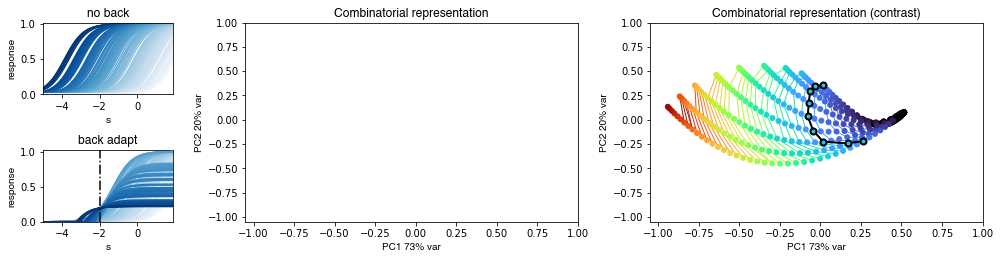

shift_y


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


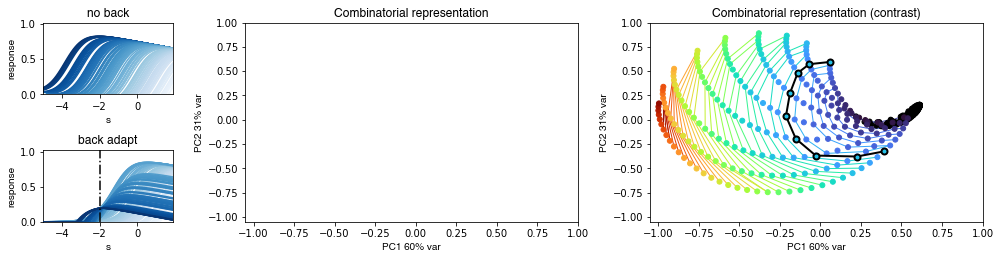

In [24]:
font = {'family': 'helvetica'}
plt.rcParams['pdf.fonttype'] = 'truetype'
par_case = 2
for norm_par in np.array([0,1]):
    print(string[par_case])
    ## ----- Figure parameters ------
    markers = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']
    color_map_neurons = plt.cm.Blues_r
    color_map_pca = plt.cm.turbo#nipy_spectral
    norm = Normalize(vmin=0, vmax=5)
    norm_contrast = Normalize(vmin=0, vmax=0.7)
    plt.figure(figsize=(14, 3.7))
    gs = gridspec.GridSpec(2, 5)  # 2 rows, 5 columns grid
    ax1 = plt.subplot(gs[0, 0])  # This subplot spans the first column of the first row
    ax2 = plt.subplot(gs[1, 0])  # This subplot spans the first column of the second row
    ax3 = plt.subplot(gs[:, 1:3])  # This spans all rows and the last two columns
    ax4 = plt.subplot(gs[:, 3:])  # This spans all rows and the last two columns
    ax1.set_title('no back', fontdict=font)
    ax1.set_xlabel('s', fontdict=font)
    ax1.set_ylabel('response', fontdict=font)
    ax1.set_xlim([-5, 1.9])
    ax1.set_ylim([0, 1.02])
    ax2.set_title('back adapt', fontdict=font)
    ax2.set_xlabel('s', fontdict=font)
    ax2.set_ylabel('response', fontdict=font)
    ax2.set_xlim([-5, 1.9])
    ax2.set_ylim([0, 1.02])
    ax3.set_title('Combinatorial representation', fontdict=font)
    ax3.set_xlim([-6, 7])
    ax3.set_ylim([-5., 5.])
    ax4.set_title('Combinatorial representation (contrast)', fontdict=font)
    ax4.set_xlim([-6, 7])
    ax4.set_ylim([-5., 5])

    ci_0 = 4
    module_par = 8
    
    ## ----- Response of the neuronal population ----
    if norm_par == 0:  
        for i_N in range(N):
            r = Adapt_function(s_array, np.sort(alpha_array)[i_N], np.sort(x0_array)[i_N], np.sort(b_array)[i_N]) # Response with non-adapted parameters
            ci = ci_0 + x0_array[i_N]
            ax1.plot(s_array, r, color=color_map_neurons(0.8*norm(ci % module_par)))
    else:
        for i_N in range(N):
            r = Adapt_function(s_array, np.sort(alpha_array)[i_N], np.sort(x0_array)[i_N], np.sort(b_array)[i_N]) - 0.05*(5 + s_array)  # Response with non-adapted parameters
            ci = ci_0 + x0_array[i_N]
            ax1.plot(s_array, r, color=color_map_neurons(0.8*norm(ci % module_par)))

    ## ------- Combinatorial response -------

    Back_array = np.array([0.5, -0.1, -0.5, -1, -1.5, -2, -2.5, -3, -3.5])
    N_back = Back_array.size
    N_t = 40
#     test_array = np.linspace(0.5, 2, num=N_t)
    test_array = np.linspace(-3.4, 2, num=N_t)
    r_test = np.zeros((N_back*N_t + N_t, N))
    r_test_norm = np.zeros((N_back*N_t + N_t, N))
    r_test_n = np.zeros((N_back*N_t + N_t, N))
    r_b_array = np.zeros((s_array.size, N))
    alpha_norm = np.ones(N)
    
    
    for i_back in range(N_back):
        x0_array_a = np.copy(x0_array)
        alpha_array_a = np.copy(alpha_array)
        b_array_a = np.copy(b_array)
        s_back = Back_array[i_back]
        for i_N in range(N):
            r_b = Adapt_function(s_back, alpha_array[i_N], x0_array[i_N], b_array[i_N])
            if r_b > th:
                if par_case == 0: 
                    x0_array_a[i_N] += r_b
                if par_case == 1:
                    alpha_array_a[i_N] = 1 - 0.8*r_b
                if par_case == 2:
                    b_array_a[i_N] = 0.8*r_b
                    
            r_adapt = Adapt_function(s_array, alpha_array_a[i_N], x0_array_a[i_N], b_array_a[i_N])
            r_b_array[:, i_N] = np.copy(r_adapt)
             
                
        link_neurons = np.arange(N)
        for i_t in range(N_t):
            r_test[i_t, :] = Adapt_function(test_array[i_t], alpha_array.flatten(), x0_array.flatten(), b_array.flatten())
            r_test[(i_back+1)*N_t + i_t, :]= Adapt_function(test_array[i_t], alpha_array_a.flatten(), x0_array_a.flatten(), b_array_a.flatten())
            
            contrast_zeroback = 5 + test_array[i_t]
#             contrast_stim = np.abs(test_array[i_t] - s_back)
            if  (5 + s_back) - (5 + test_array[i_t]) < 0:
                contrast_stim =  5 + test_array[i_t] - ( 5 + s_back)
            else:
                contrast_stim = 0

            r_test_norm[i_t, :] = 2*(r_test[i_t, :] - 0.05*contrast_zeroback)
            r_test_norm[(i_back+1)*N_t + i_t, :] = 2*(r_test[(i_back+1)*N_t + i_t, :] - 0.05*contrast_stim)
#             r_test_norm[i_t, :] = 2*(r_test[i_t, :]/(0.01 + contrast_zeroback)) #- 0.01*contrast_zeroback)
#             r_test_norm[(i_back+1)*N_t + i_t, :]= 2*(r_test[(i_back+1)*N_t + i_t, :]/(0.01 + contrast_stim)) #- 0.01*contrast_stim)
#             r_test_norm[i_t, :] = 2*(r_test[i_t, :]/(1 + r_test[i_t, :] + alpha_norm[link_neurons]*np.mean(r_test[i_t, link_neurons])))
#             r_test_norm[(i_back+1)*N_t + i_t, :]= 2*(r_test[(i_back+1)*N_t + i_t, :]/(1 + r_test[(i_back+1)*N_t + i_t, :] + alpha_norm[link_neurons]*np.mean(r_test[(i_back+1)*N_t + i_t, link_neurons])) )
                
            r_test_n[i_t, :] = np.copy(r_test[(i_back+1)*N_t + i_t, :])
            r_test_n[(i_back+1)*N_t + i_t, :] = np.copy(r_test_norm[(i_back+1)*N_t + i_t, :])
                
        if norm_par == 1:  
#             ax3.set_xlim([-10, 8.5])
#             ax3.set_ylim([-10., 10.])
#             ax4.set_xlim([-10, 8.5])
#             ax4.set_ylim([-10., 10])
            
            ax3.set_xlim([-1.05, 1.])
            ax3.set_ylim([-1.05, 1.])
            ax4.set_xlim([-1.05, 1.])
            ax4.set_ylim([-1.05,1])
            r_test = r_test_norm
            if s_back == -2:
                ax2.axvline(x=-2, color = 'k', linestyle = '-.', zorder = 1000)
                for i_N in range(N):
#                     contrast_stim = np.abs(s_array - s_back)
                    contrast_stim =  5 + s_array - ( 5 + s_back)
                    contrast_stim[np.where(contrast_stim < 0)] = 0
                    
#                     contrast_stim = 4 + s_back
                    #r_a = Adapt_function(s_array, alpha_array_a[i_N], x0_array_a[i_N], b_array_a[i_N])/(1 + Adapt_function(s_array,alpha_array_a[i_N], x0_array_a[i_N], b_array_a[i_N]) + alpha_norm[i_N]*np.mean(r_b_array[:,link_neurons], axis = 1))
                    r_a = Adapt_function(s_array, alpha_array_a[i_N], x0_array_a[i_N], b_array_a[i_N]) - 0.05*contrast_stim
                    ci = ci_0 + x0_array[i_N]
                    ax2.plot(s_array, r_a, color=color_map_neurons(0.8*norm(ci % module_par)), zorder = 100 - x0_array[i_N])

        else:
#             ax3.set_xlim([-8, 5.])
#             ax3.set_ylim([-5., 5.])
#             ax4.set_xlim([-8, 5.])
#             ax4.set_ylim([-5., 5])
            
            ax3.set_xlim([-1.05, 1.])
            ax3.set_ylim([-1.05, 1.])
            ax4.set_xlim([-1.05, 1.])
            ax4.set_ylim([-1.05,1])
            if s_back == -2:
                ax2.axvline(x=-2, color = 'k', linestyle = '-.', zorder = 1000)
                for i_N in range(N):
                    r_a = Adapt_function(s_array, alpha_array_a[i_N], x0_array_a[i_N], b_array_a[i_N])
                    ci = ci_0 + x0_array[i_N]#+ int(np.round(x0_array[i_N]))
                    ax2.plot(s_array, r_a, color=color_map_neurons(0.8*norm(ci % module_par)), zorder = 100 - x0_array[i_N])  
    
    pca = PCA(n_components=2)
    if norm_par == 1:
        score = pca.fit_transform(r_test)
    else: 
        score = pca.fit_transform(r_test)
    contrast_array = np.zeros((N_back, N_t))
    contrast_array_ = np.zeros((N_back, N_t))
    
    score /= np.max(np.abs(score))
    
    ci_0 = 11.
    ci_contrast_0 = 0
    module_par = 8
    weight_par = 0.8
    
    if score.shape[0] > 0:
        ci_contrast_array = np.zeros(( N_back, N_t ))
        counter_back = 0
        for i_back in range(1, N_back+1):
            counter_back += 1

            
            ci = ci_0 + test_array     
            ci_color = color_map_pca(weight_par*norm(ci % module_par))
            contrast_ = (((test_array + 10) - ( Back_array[i_back-1] + 10))/( Back_array[i_back-1] + 10) )
            ci_contrast = contrast_ + ci_contrast_0
            ci_contrast_color = color_map_pca(weight_par*norm_contrast(ci_contrast % module_par))
            
            ci_contrast_color[np.where(contrast_<0)[0]] = plt.cm.Greys(weight_par*norm_contrast(10)) # OFF-stimuli
            ci_color[np.where(contrast_<0)[0]] = plt.cm.Greys(weight_par*norm_contrast(10))
            contrast_array_[counter_back-1,:] = ci_contrast 
            ci_contrast[np.where(contrast_<0)[0]] = 0 # OFF-stimuli
            ci[np.where(contrast_<0)[0]] = 0
        
            contrast_array[counter_back-1,:] = weight_par*norm_contrast(ci_contrast %  module_par)
            
            if norm_par == 1:
#                 ax3.scatter(-score[i_back*N_t:i_back*N_t + N_t, 0], -score[i_back*N_t:i_back*N_t + N_t, 1], label=r'$S_b = $'+str(np.round(Back_array[i_back-1], decimals = 2)), color = ci_color , marker = markers[i_back - 1], s =  25) #+ counter_back**(2))
                ax4.scatter(-score[i_back*N_t:i_back*N_t + N_t, 0], -score[i_back*N_t:i_back*N_t + N_t, 1], label=r'$S_b = $'+str(np.round(Back_array[i_back-1], decimals = 2)), color = ci_contrast_color , marker = markers[i_back - 1], s =  25) #+ counter_back**(2))
            else:
#                 ax3.scatter(-score[i_back*N_t:i_back*N_t + N_t, 0], -score[i_back*N_t:i_back*N_t + N_t, 1], label=r'$S_b = $'+str(np.round(Back_array[i_back-1], decimals = 2)), color = ci_color , marker = markers[i_back - 1], s =  25) #+ counter_back**(2))
                ax4.scatter(-score[i_back*N_t:i_back*N_t + N_t, 0], -score[i_back*N_t:i_back*N_t + N_t, 1], label=r'$S_b = $'+str(np.round(Back_array[i_back-1], decimals = 2)), color = ci_contrast_color , marker = markers[i_back - 1], s =  25) #+ counter_back**(2))

        ax3.set_xlabel('PC1 {:.0f}% var'.format(pca.explained_variance_ratio_[0] * 100), fontdict=font)
        ax3.set_ylabel('PC2 {:.0f}% var'.format(pca.explained_variance_ratio_[1] * 100), fontdict=font)
        ax4.set_xlabel('PC1 {:.0f}% var'.format(pca.explained_variance_ratio_[0] * 100), fontdict=font)
        ax4.set_ylabel('PC2 {:.0f}% var'.format(pca.explained_variance_ratio_[1] * 100), fontdict=font)
    
    contrast_array_0 = (test_array - Back_array[0])/Back_array[0] 
    for i_t in range(N_t):        
        idx_array = np.array([0])
        for i_b_ in range(0, N_back):
            i_b = N_back - 1 - i_b_
            idx = np.where(contrast_array_[i_b,:]>=contrast_array_[-2, i_t])[0]
            #idx = np.where(contrast_array[i_b,:]>=contrast_array[N_back-1, i_t])[0]
            if idx.size >= 1:
                idx_array = np.append(idx_array, idx[0])
        idx_array_ = np.copy(idx_array[1:])
        
        if idx_array_.size > 1:
            
            idx_array_back = N_back - idx_array_.size
            
            if i_t == int(N_t/2) - 10:
                if norm_par == 1:
                    ax4.plot(-score[np.flip(np.arange(idx_array_back+1, N_back+1))*N_t + idx_array_, 0], -score[np.flip(np.arange(idx_array_back+1, N_back+1))*N_t + idx_array_, 1], color = 'k', zorder = 10, linewidth = 2, marker = 'o', markeredgecolor = 'k', markerfacecolor = color_map_pca(contrast_array[-1, i_t]), markeredgewidth = 2)
                else:
                    ax4.plot(-score[np.flip(np.arange(idx_array_back+1, N_back+1))*N_t + idx_array_, 0], -score[np.flip(np.arange(idx_array_back+1, N_back+1))*N_t + idx_array_, 1], color = 'k', zorder = 10, linewidth = 2, marker = 'o', markeredgecolor = 'k', markerfacecolor = color_map_pca(contrast_array[-1, i_t]), markeredgewidth = 2)
            else:
                if norm_par == 1:
                    ax4.plot(-score[np.flip(np.arange(idx_array_back+1, N_back+1))*N_t + idx_array_, 0], -score[np.flip(np.arange(idx_array_back+1, N_back+1))*N_t + idx_array_, 1], color = color_map_pca(contrast_array[-1, i_t]), zorder = 0, linewidth = 1)
                else:
                    ax4.plot(-score[np.flip(np.arange(idx_array_back+1, N_back+1))*N_t + idx_array_, 0], -score[np.flip(np.arange(idx_array_back+1, N_back+1))*N_t + idx_array_, 1], color = color_map_pca(contrast_array[-1, i_t]), zorder = 0, linewidth = 1)

    plt.tight_layout()
#     plt.savefig("Figures/PCA_population_ORNs"+str(string[par_case])+"_adaptation_"+str(string_norm[norm_par])+"_SubNorm.pdf", bbox_inches = 'tight', dpi = 300)
    plt.show()
        

### Population of PNs

shift_y
PCA between non-adapted and adapted and nornalized responses


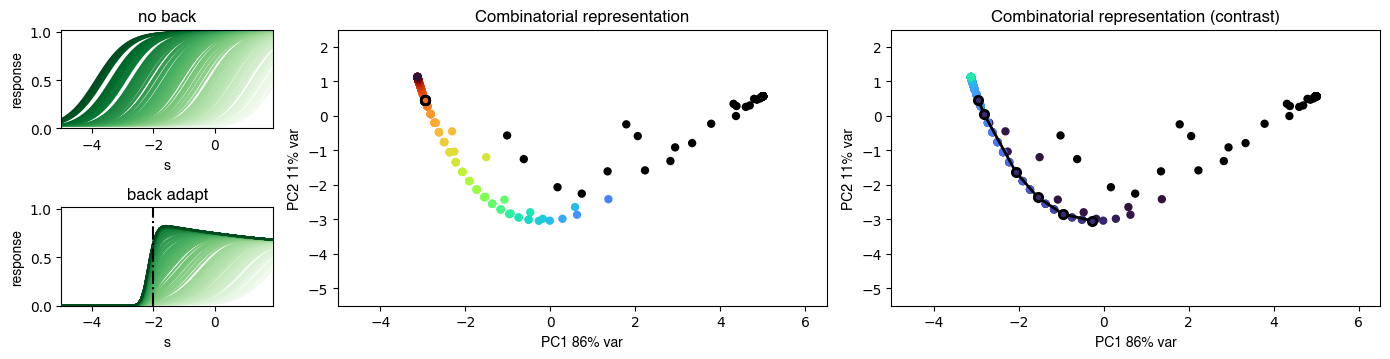

In [25]:
font = {'family': 'helvetica'}
plt.rcParams['pdf.fonttype'] = 'truetype'

    
print(string[par_case])
## ----- Figure parameters ------
markers = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']
color_map_neurons = plt.cm.Greens_r
color_map_pca = plt.cm.turbo#nipy_spectral
norm = Normalize(vmin=0, vmax=5)
norm_contrast = Normalize(vmin=0, vmax=2)
plt.figure(figsize=(14, 3.7))
gs = gridspec.GridSpec(2, 5)  # 2 rows, 5 columns grid
ax1 = plt.subplot(gs[0, 0])  # This subplot spans the first column of the first row
ax2 = plt.subplot(gs[1, 0])  # This subplot spans the first column of the second row
ax3 = plt.subplot(gs[:, 1:3])  # This spans all rows and the last two columns
ax4 = plt.subplot(gs[:, 3:])  # This spans all rows and the last two columns
ax1.set_title('no back', fontdict=font)
ax1.set_xlabel('s', fontdict=font)
ax1.set_ylabel('response', fontdict=font)
ax1.set_xlim([-5, 1.9])
ax1.set_ylim([0, 1.02])
ax2.set_title('back adapt', fontdict=font)
ax2.set_xlabel('s', fontdict=font)
ax2.set_ylabel('response', fontdict=font)
ax2.set_xlim([-5, 1.9])
ax2.set_ylim([0, 1.02])
ax3.set_title('Combinatorial representation', fontdict=font)
ax3.set_xlim([-6, 7])
ax3.set_ylim([-5., 5.])
ax4.set_title('Combinatorial representation (contrast)', fontdict=font)
ax4.set_xlim([-6, 7])
ax4.set_ylim([-5., 5])

ci_0 = 4
module_par = 8

## ----- Response of the neuronal population ----
for i_N in range(N):
    r = Adapt_function(s_array, np.sort(alpha_array)[i_N], np.sort(x0_array)[i_N], np.sort(b_array)[i_N]) # Response with non-adapted parameters
    ci = ci_0 + x0_array[i_N]
    ax1.plot(s_array, r, color=color_map_neurons(0.8*norm(ci % module_par)))

## ------- Combinatorial response -------

Back_array = np.array([1, 0.5, -0.5,-1,-1.5, -2])
N_back = Back_array.size
N_t = 50
test_array = np.linspace(-4, 5, num=N_t)
r_test = np.zeros((N_back*N_t + N_t, N))
r_test_norm = np.zeros((N_back*N_t + N_t, N))
r_b_array = np.zeros((s_array.size, N))
alpha_norm = np.ones(N)

sigma = 0.2
    
if norm_par == 1:
    print('PCA between non-adapted and adapted and nornalized responses')
if norm_par == 0:
    print('PCA between non-adapted and adapted and Non-nornalized responses')
    
for i_back in range(N_back):
    x0_array_a = np.copy(x0_array)
    alpha_array_a = np.copy(alpha_array)
    b_array_a = np.copy(b_array)
    s_back = Back_array[i_back]
    
    weight = Prob(s_array, sigma, s_back)
    weight = np.cumsum(weight)/np.max(np.cumsum(weight))
    
    for i_N in range(N):
        idx = np.where(s_array<(s_back + np.random.normal(0, 0.2)))[0]
        r_b = Adapt_function(s_back, alpha_array[i_N], x0_array[i_N], b_array[i_N])
        r_adapt = Adapt_function(s_array, alpha_array_a[i_N], x0_array_a[i_N], b_array_a[i_N])
        r_adapt *= weight 
        r_b_array[:, i_N] = np.copy(r_adapt)

    link_neurons = np.arange(N)
    for i_t in range(N_t):
        val1 = Adapt_function(test_array[i_t], alpha_array.flatten(), x0_array.flatten(), b_array.flatten())
        r_test[i_t, :] = Adapt_function(test_array[i_t], alpha_array.flatten(), x0_array.flatten(), b_array.flatten()) #         if test_array[i_t]<s_back:
        idx_cumsum = np.where(s_array>test_array[i_t])[0][0]
        val2 = Adapt_function(test_array[i_t], alpha_array.flatten(), x0_array.flatten(), b_array.flatten())*weight[idx_cumsum]           
        r_test[(i_back+1)*N_t + i_t, :]= val2
        r_test_norm[i_t, :] = 2*(val1/(1 + val1 + alpha_norm[link_neurons]*np.mean(r_test[i_t, link_neurons])))
        r_test_norm[(i_back+1)*N_t + i_t, :]= 2*(val2/(1 + val2 + alpha_norm[link_neurons]*np.mean(r_test[(i_back+1)*N_t + i_t, link_neurons])) )

    if norm_par == 1:  
        ax3.set_xlim([-5, 6.5])
        ax3.set_ylim([-5.5, 2.5])
        ax4.set_xlim([-5, 6.5])
        ax4.set_ylim([-5.5, 2.5])
        r_test = r_test_norm
        if s_back == -2:
            ax2.axvline(x=-2, color = 'k', linestyle = '-.', zorder = 1000)
            for i_N in range(N):
                r_a = Adapt_function(s_array, alpha_array[i_N], x0_array[i_N], b_array[i_N])*weight
                r_a = r_a/(1 + r_a + np.mean(r_b_array[:,link_neurons], axis = 1) )
#                 idx = np.where(s_array<s_back)[0]
#                 r_a[idx] = np.zeros(idx.size)
                ci = ci_0 + x0_array[i_N]
                ax2.plot(s_array, r_a/0.5, color=color_map_neurons(0.8*norm(ci % module_par)), zorder = 100 - x0_array[i_N])

    else:
        ax3.set_xlim([-6, 9])
        ax3.set_ylim([-8., 5.])
        ax4.set_xlim([-6, 9])
        ax4.set_ylim([-8., 5])
        if s_back == -2:
            ax2.axvline(x=-2, color = 'k', linestyle = '-.', zorder = 1000)
            for i_N in range(N):
                r_a = Adapt_function(s_array, alpha_array[i_N], x0_array[i_N], b_array[i_N])*weight
#                 r_a = Adapt_function(s_array, alpha_array[i_N], x0_array[i_N], b_array[i_N])
#                 idx = np.where(s_array<s_back)[0]
#                 r_a[idx] = np.zeros(idx.size)
                ci = ci_0 + x0_array[i_N]#+ int(np.round(x0_array[i_N]))
                ax2.plot(s_array, r_a, color=color_map_neurons(0.8*norm(ci % module_par)), zorder = 100 - x0_array[i_N])  

pca = PCA(n_components=2)
score = pca.fit_transform(r_test) # Transpose rtest to align samples and features for PCA
contrast_array = np.zeros((N_back, N_t))

ci_0 = 11.
ci_contrast_0 = 0
module_par = 8
weight_par = 0.8

if score.shape[0] > 0:
    ci_contrast_array = np.zeros(( N_back, N_t ))
    counter_back = 0
    for i_back in range(1, N_back+1):
        counter_back += 1

        ci = ci_0 + test_array     
        ci_color = color_map_pca(weight_par*norm(ci % module_par))
        contrast_ = (((test_array + 10) - ( Back_array[i_back-1] + 10))/( Back_array[i_back-1] + 10) )
        ci_contrast = contrast_ + ci_contrast_0
        ci_contrast_color = color_map_pca(weight_par*norm_contrast(ci_contrast % module_par))

        ci_contrast_color[np.where(contrast_<0)[0]] = plt.cm.Greys_r(weight_par*norm_contrast(0)) # OFF-stimuli
        ci_color[np.where(contrast_<0)[0]] = plt.cm.Greys_r(weight_par*norm_contrast(0))
        ci_contrast[np.where(contrast_<0)[0]] = 0 # OFF-stimuli
        ci[np.where(contrast_<0)[0]] = 0

        contrast_array[counter_back-1,:] = weight_par*norm_contrast(ci_contrast %  module_par)

        ax3.scatter(score[i_back*N_t:i_back*N_t + N_t, 0], -score[i_back*N_t:i_back*N_t + N_t, 1], label=r'$S_b = $'+str(np.round(Back_array[i_back-1], decimals = 2)), color = ci_color , marker = markers[i_back - 1], s =  25) #+ counter_back**(2))
        ax4.scatter(score[i_back*N_t:i_back*N_t + N_t, 0], -score[i_back*N_t:i_back*N_t + N_t, 1], label=r'$S_b = $'+str(np.round(Back_array[i_back-1], decimals = 2)), color = ci_contrast_color , marker = markers[i_back - 1], s =  25) #+ counter_back**(2))

    ax3.set_xlabel('PC1 {:.0f}% var'.format(pca.explained_variance_ratio_[0] * 100), fontdict=font)
    ax3.set_ylabel('PC2 {:.0f}% var'.format(pca.explained_variance_ratio_[1] * 100), fontdict=font)
    ax4.set_xlabel('PC1 {:.0f}% var'.format(pca.explained_variance_ratio_[0] * 100), fontdict=font)
    ax4.set_ylabel('PC2 {:.0f}% var'.format(pca.explained_variance_ratio_[1] * 100), fontdict=font)

contrast_array_0 = (test_array - Back_array[0])/Back_array[0] 
for i_t in range(N_t):
    if i_t == int(N_t/2) + 7:
        ax3.plot(score[i_t + N_t*np.arange(1, N_back+1), 0], -score[i_t + N_t*np.arange(1, N_back+1), 1], color = 'k', linewidth = 2, zorder = 10, marker = 'o', markeredgecolor = 'k', markerfacecolor = color_map_pca(weight_par*norm(ci[i_t] % module_par)), markeredgewidth = 2) #+ counter_back**(2))
#     else:
    #ax3.plot(score[i_t + N_t*np.arange(1, N_back+1), 0], -score[i_t + N_t*np.arange(1, N_back+1), 1], color = color_map_pca(weight_par*norm(ci[i_t] % module_par)), linewidth = 1, zorder = 0) #+ counter_back**(2))
    idx_array = np.array([0])
    for i_b in range(0, N_back):
        idx = np.where(contrast_array[i_b,:]>=contrast_array[0, i_t])[0]
        if idx.size > 1:
            idx_array = np.append(idx_array, idx[0])
    idx_array_ = idx_array[1:]
    if idx_array_.size > 1:
        if i_t == int(N_t/2) + 7:
            ax4.plot(score[np.arange(1, idx_array_.size+1)*N_t + idx_array_, 0], -score[np.arange(1, idx_array_.size+1)*N_t + idx_array_, 1], color = 'k', zorder = 10, linewidth = 2, marker = 'o', markeredgecolor = 'k', markerfacecolor = color_map_pca(contrast_array[0, i_t]), markeredgewidth = 2)
#         else:
#             ax4.plot(score[np.arange(1, idx_array_.size+1)*N_t + idx_array_, 0], -score[np.arange(1, idx_array_.size+1)*N_t + idx_array_, 1], color = color_map_pca(contrast_array[0, i_t]), zorder = 0, linewidth = 1)

plt.tight_layout()
#plt.savefig("Figures/PCA_PNs_population_"+str(string_norm[norm_par])+".pdf", bbox_inches = 'tight', dpi = 300)
plt.show()
        

#### PCA between normalized and unnormalized adapted responses

shift_y


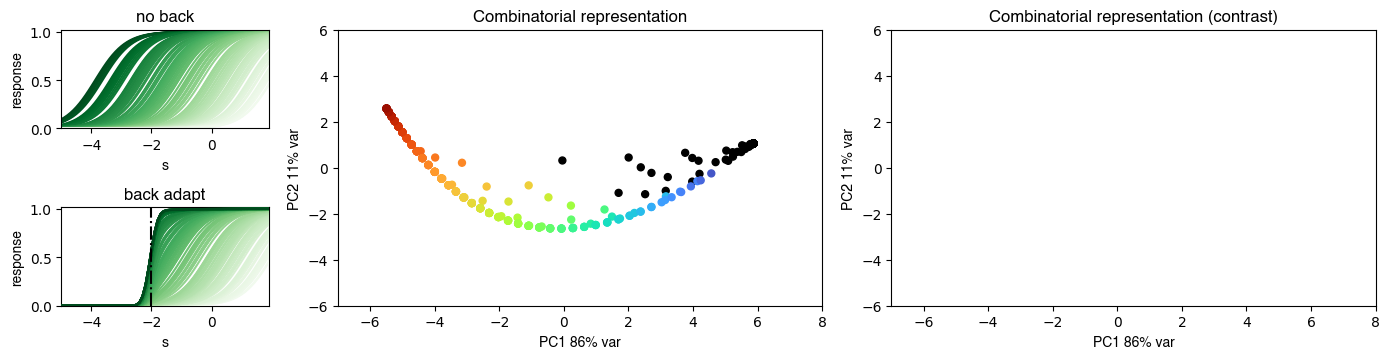

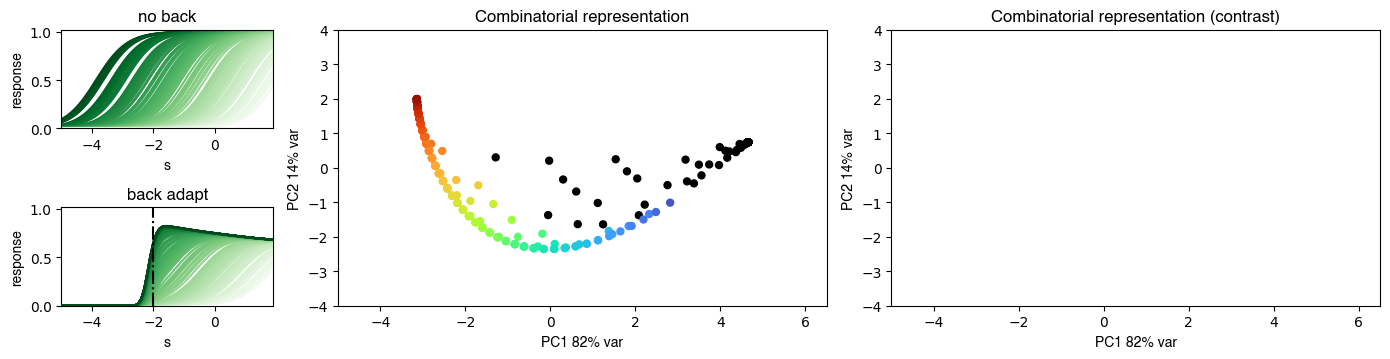

In [24]:
font = {'family': 'helvetica'}
plt.rcParams['pdf.fonttype'] = 'truetype'

    
print(string[par_case])
## ----- Figure parameters ------
markers = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']
color_map_neurons = plt.cm.Greens_r
color_map_pca = plt.cm.turbo#nipy_spectral
norm = Normalize(vmin=0, vmax=5)
norm_contrast = Normalize(vmin=0, vmax=2)
for norm_par in np.array([0, 1]):
    plt.figure(figsize=(14, 3.7))
    gs = gridspec.GridSpec(2, 5)  # 2 rows, 5 columns grid
    ax1 = plt.subplot(gs[0, 0])  # This subplot spans the first column of the first row
    ax2 = plt.subplot(gs[1, 0])  # This subplot spans the first column of the second row
    ax3 = plt.subplot(gs[:, 1:3])  # This spans all rows and the last two columns
    ax4 = plt.subplot(gs[:, 3:])  # This spans all rows and the last two columns
    ax1.set_title('no back', fontdict=font)
    ax1.set_xlabel('s', fontdict=font)
    ax1.set_ylabel('response', fontdict=font)
    ax1.set_xlim([-5, 1.9])
    ax1.set_ylim([0, 1.02])
    ax2.set_title('back adapt', fontdict=font)
    ax2.set_xlabel('s', fontdict=font)
    ax2.set_ylabel('response', fontdict=font)
    ax2.set_xlim([-5, 1.9])
    ax2.set_ylim([0, 1.02])
    ax3.set_title('Combinatorial representation', fontdict=font)
    # ax3.set_xlim([-6, 7])
    # ax3.set_ylim([-5., 5.])
    ax4.set_title('Combinatorial representation (contrast)', fontdict=font)
    # ax4.set_xlim([-6, 7])
    # ax4.set_ylim([-5., 5])

    ci_0 = 4
    module_par = 8

    ## ----- Response of the neuronal population ----
    for i_N in range(N):
        r = Adapt_function(s_array, np.sort(alpha_array)[i_N], np.sort(x0_array)[i_N], np.sort(b_array)[i_N]) # Response with non-adapted parameters
        ci = ci_0 + x0_array[i_N]
        ax1.plot(s_array, r, color=color_map_neurons(0.8*norm(ci % module_par)))

    ## ------- Combinatorial response -------

    # Back_array = np.array([1, 0.5, -0.5,-1,-1.5, -2])
    Back_array = np.array([0.5, -0.1, -0.5, -1, -1.5, -2, -2.5, -3, -3.5])
    N_back = Back_array.size
    N_t = 40
    test_array = np.linspace(-3.4, 2, num=N_t)
    # test_array = np.linspace(-4, 5, num=N_t)
    r_test = np.zeros((N_back*N_t + N_t, N))
    r_test_norm = np.zeros((N_back*N_t + N_t, N))
    r_test_n = np.zeros((N_back*N_t + N_t, N))
    r_b_array = np.zeros((s_array.size, N))
    alpha_norm = np.ones(N)

    sigma = 0.2

    for i_back in range(N_back):
        x0_array_a = np.copy(x0_array)
        alpha_array_a = np.copy(alpha_array)
        b_array_a = np.copy(b_array)
        s_back = Back_array[i_back]

        weight = Prob(s_array, sigma, s_back)
        weight = np.cumsum(weight)/np.max(np.cumsum(weight))

        for i_N in range(N):
            idx = np.where(s_array<(s_back + np.random.normal(0, 0.2)))[0]
            r_b = Adapt_function(s_back, alpha_array[i_N], x0_array[i_N], b_array[i_N])
            r_adapt = Adapt_function(s_array, alpha_array_a[i_N], x0_array_a[i_N], b_array_a[i_N])
            r_adapt *= weight 
            r_b_array[:, i_N] = np.copy(r_adapt)

        link_neurons = np.arange(N)
        for i_t in range(N_t):
            val1 = Adapt_function(test_array[i_t], alpha_array.flatten(), x0_array.flatten(), b_array.flatten())
            r_test[i_t, :] = Adapt_function(test_array[i_t], alpha_array.flatten(), x0_array.flatten(), b_array.flatten()) #         if test_array[i_t]<s_back:
            idx_cumsum = np.where(s_array>=test_array[i_t])[0][0]
            val2 = Adapt_function(test_array[i_t], alpha_array.flatten(), x0_array.flatten(), b_array.flatten())*weight[idx_cumsum]           
            r_test[(i_back+1)*N_t + i_t, :] = val2
            r_test_norm[i_t, :] = 2*(val1/(1 + val1 + alpha_norm[link_neurons]*np.mean(r_test[i_t, link_neurons])))
            r_test_norm[(i_back+1)*N_t + i_t, :]= 2*(val2/(1 + val2 + alpha_norm[link_neurons]*np.mean(r_test[(i_back+1)*N_t + i_t, link_neurons])) )

            r_test_n[i_t, :] = np.copy(val2)
            r_test_n[(i_back+1)*N_t + i_t, :] = 2*(val2/(1 + val2 + alpha_norm[link_neurons]*np.mean(r_test[(i_back+1)*N_t + i_t, link_neurons])) )


        if norm_par == 1:  
            ax3.set_xlim([-5, 6.5])
            ax3.set_ylim([-4., 4])
            ax4.set_xlim([-5, 6.5])
            ax4.set_ylim([-4, 4])
            r_test = r_test_norm
            if s_back == -2:
                ax2.axvline(x=-2, color = 'k', linestyle = '-.', zorder = 1000)
                for i_N in range(N):
                    r_a = Adapt_function(s_array, alpha_array[i_N], x0_array[i_N], b_array[i_N])*weight
                    r_a = r_a/(1 + r_a + np.mean(r_b_array[:,link_neurons], axis = 1) )
                    ci = ci_0 + x0_array[i_N]
                    ax2.plot(s_array, r_a/0.5, color=color_map_neurons(0.8*norm(ci % module_par)), zorder = 100 - x0_array[i_N])

        else:
            ax3.set_xlim([-7, 8])
            ax3.set_ylim([-6., 6.])
            ax4.set_xlim([-7, 8])
            ax4.set_ylim([-6., 6])
            if s_back == -2:
                ax2.axvline(x=-2, color = 'k', linestyle = '-.', zorder = 1000)
                for i_N in range(N):
                    r_a = Adapt_function(s_array, alpha_array[i_N], x0_array[i_N], b_array[i_N])*weight
                    ci = ci_0 + x0_array[i_N]#+ int(np.round(x0_array[i_N]))
                    ax2.plot(s_array, r_a, color=color_map_neurons(0.8*norm(ci % module_par)), zorder = 100 - x0_array[i_N])  

    pca = PCA(n_components=2)
    score = pca.fit_transform(r_test) # Transpose rtest to align samples and features for PCA
    contrast_array = np.zeros((N_back, N_t))

    ci_0 = 12.
    ci_contrast_0 = 0
    module_par = 8
    weight_par = 0.8

    if score.shape[0] > 0:
        ci_contrast_array = np.zeros(( N_back, N_t ))
        counter_back = 0
        for i_back in range(1, N_back+1):
            counter_back += 1

            ci = ci_0 + test_array     
            ci_color = color_map_pca(weight_par*norm(ci % module_par))
            contrast_ = (((test_array + 10) - ( Back_array[i_back-1] + 10))/( Back_array[i_back-1] + 10) )
            ci_contrast = contrast_ + ci_contrast_0
            ci_contrast_color = color_map_pca(weight_par*norm_contrast(ci_contrast % module_par))

            ci_contrast_color[np.where(contrast_<0)[0]] = plt.cm.Greys_r(weight_par*norm_contrast(0)) # OFF-stimuli
            ci_color[np.where(contrast_<0)[0]] = plt.cm.Greys_r(weight_par*norm_contrast(0))
            ci_contrast[np.where(contrast_<0)[0]] = 0 # OFF-stimuli
            ci[np.where(contrast_<0)[0]] = 0

            contrast_array[counter_back-1,:] = weight_par*norm_contrast(ci_contrast %  module_par)

            ax3.scatter(score[i_back*N_t:i_back*N_t + N_t, 0], -score[i_back*N_t:i_back*N_t + N_t, 1], label=r'$S_b = $'+str(np.round(Back_array[i_back-1], decimals = 2)), color = ci_color , marker = markers[i_back - 1], s =  25) #+ counter_back**(2))

        ax3.set_xlabel('PC1 {:.0f}% var'.format(pca.explained_variance_ratio_[0] * 100), fontdict=font)
        ax3.set_ylabel('PC2 {:.0f}% var'.format(pca.explained_variance_ratio_[1] * 100), fontdict=font)
        ax4.set_xlabel('PC1 {:.0f}% var'.format(pca.explained_variance_ratio_[0] * 100), fontdict=font)
        ax4.set_ylabel('PC2 {:.0f}% var'.format(pca.explained_variance_ratio_[1] * 100), fontdict=font)

    contrast_array_0 = (test_array - Back_array[0])/Back_array[0] 
    for i_t in range(N_t):
        idx_array = np.array([0])
        for i_b in range(0, N_back):
            idx = np.where(contrast_array[i_b,:]>=contrast_array[0, i_t])[0]
            if idx.size > 1:
                idx_array = np.append(idx_array, idx[0])
        idx_array_ = idx_array[1:]

    plt.tight_layout()
    #plt.savefig("Figures/PCA_PNs_population_"+str(string_norm[norm_par])+"_sparse.pdf", bbox_inches = 'tight', dpi = 300)
    plt.show()
        

### Plotting histograms

#### ORNs

shift_y


/Users/fernanda/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


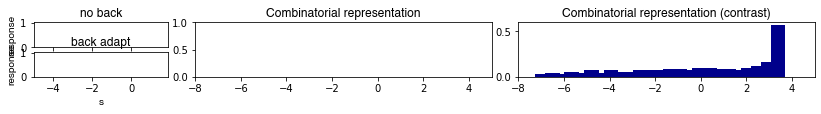

shift_y


/Users/fernanda/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


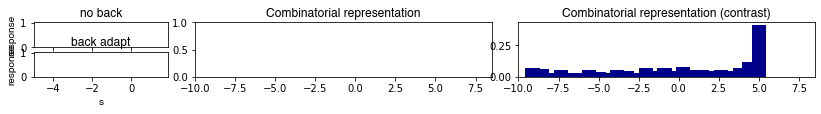

In [24]:
font = {'family': 'helvetica'}
plt.rcParams['pdf.fonttype'] = 'truetype'
par_case = 2
for norm_par in np.array([0,1]):
    print(string[par_case])
    ## ----- Figure parameters ------
    markers = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']
    color_map_neurons = plt.cm.Blues_r
    color_map_pca = plt.cm.turbo#nipy_spectral
    norm = Normalize(vmin=0, vmax=5)
    norm_contrast = Normalize(vmin=0, vmax=2)
    plt.figure(figsize=(14, 1.))
    gs = gridspec.GridSpec(2, 5)  # 2 rows, 5 columns grid
    ax1 = plt.subplot(gs[0, 0])  # This subplot spans the first column of the first row
    ax2 = plt.subplot(gs[1, 0])  # This subplot spans the first column of the second row
    ax3 = plt.subplot(gs[:, 1:3])  # This spans all rows and the last two columns
    ax4 = plt.subplot(gs[:, 3:])  # This spans all rows and the last two columns
    ax1.set_title('no back', fontdict=font)
    ax1.set_xlabel('s', fontdict=font)
    ax1.set_ylabel('response', fontdict=font)
    ax1.set_xlim([-5, 1.9])
    ax1.set_ylim([0, 1.02])
    ax2.set_title('back adapt', fontdict=font)
    ax2.set_xlabel('s', fontdict=font)
    ax2.set_ylabel('response', fontdict=font)
    ax2.set_xlim([-5, 1.9])
    ax2.set_ylim([0, 1.02])
    ax3.set_title('Combinatorial representation', fontdict=font)
    ax4.set_title('Combinatorial representation (contrast)', fontdict=font)

    ci_0 = 4
    module_par = 8
    

    ## ------- Combinatorial response -------

    Back_array = np.array([0.5, -0.1, -0.5, -1, -1.5, -2, -2.5, -3, -3.5])
    N_back = Back_array.size
    N_t = 40
    test_array = np.linspace(-3.4, 2, num=N_t)
    r_test = np.zeros((N_back*N_t + N_t, N))
    r_test_norm = np.zeros((N_back*N_t + N_t, N))
    r_test_n = np.zeros((N_back*N_t + N_t, N))
    r_b_array = np.zeros((s_array.size, N))
    alpha_norm = np.ones(N)
    
    for i_back in range(N_back):
        x0_array_a = np.copy(x0_array)
        alpha_array_a = np.copy(alpha_array)
        b_array_a = np.copy(b_array)
        s_back = Back_array[i_back]
        for i_N in range(N):
            r_b = Adapt_function(s_back, alpha_array[i_N], x0_array[i_N], b_array[i_N])
            if r_b > th:
                if par_case == 0: 
                    x0_array_a[i_N] += r_b
                if par_case == 1:
                    alpha_array_a[i_N] = 1 - 0.8*r_b
                if par_case == 2:
                    b_array_a[i_N] = 0.8*r_b
                    
            r_adapt = Adapt_function(s_array, alpha_array_a[i_N], x0_array_a[i_N], b_array_a[i_N])
            r_b_array[:, i_N] = np.copy(r_adapt)
             
                
        link_neurons = np.arange(N)
        for i_t in range(N_t):
            r_test[i_t, :] = Adapt_function(test_array[i_t], alpha_array.flatten(), x0_array.flatten(), b_array.flatten())
            r_test[(i_back+1)*N_t + i_t, :]= Adapt_function(test_array[i_t], alpha_array_a.flatten(), x0_array_a.flatten(), b_array_a.flatten())
            contrast_zeroback = 5 + test_array[i_t]
#             contrast_stim = np.abs(test_array[i_t] - s_back)
            if  (5 + s_back) - (5 + test_array[i_t]) < 0:
                contrast_stim =  5 + test_array[i_t] - ( 5 + s_back)
            else:
                contrast_stim = 0
            r_test_norm[i_t, :] = 2*(r_test[i_t, :] - 0.05*contrast_zeroback)
            r_test_norm[(i_back+1)*N_t + i_t, :] = 2*(r_test[(i_back+1)*N_t + i_t, :] - 0.05*contrast_stim)

#             r_test_norm[i_t, :] = 2*(r_test[i_t, :]/(1 + r_test[i_t, :] + alpha_norm[link_neurons]*np.mean(r_test[i_t, link_neurons])))
#             r_test_norm[(i_back+1)*N_t + i_t, :]= 2*(r_test[(i_back+1)*N_t + i_t, :]/(1 + r_test[(i_back+1)*N_t + i_t, :] + alpha_norm[link_neurons]*np.mean(r_test[(i_back+1)*N_t + i_t, link_neurons])) )
                
            r_test_n[i_t, :] = np.copy(r_test[(i_back+1)*N_t + i_t, :])
            r_test_n[(i_back+1)*N_t + i_t, :] = np.copy(r_test_norm[(i_back+1)*N_t + i_t, :])
                
        if norm_par == 1:  
            ax3.set_xlim([-10, 8.5])
            ax4.set_xlim([-10, 8.5])
            r_test = r_test_norm
        else:
            ax3.set_xlim([-8, 5.])
            ax4.set_xlim([-8, 5.])
    
    
    
    
    pca = PCA(n_components=2)
    if norm_par == 1:
        score = pca.fit_transform(r_test)
    else: 
        score = pca.fit_transform(r_test)
    contrast_array = np.zeros((N_back, N_t))
    
    ci_0 = 11.
    ci_contrast_0 = 0
    module_par = 8
    weight_par = 0.8
    
    if score.shape[0] > 0:
 
        N_bins = 25
        hist_x, hist_y = np.histogram(-score[N_t:, 0], bins=N_bins, density = True)
        dx = hist_y[1] - hist_y[0]
        ax4.bar(hist_y[:-1]+int(dx/2), hist_x, width = 1.5*dx, color = 'darkblue')    
    
    plt.tight_layout()
    plt.savefig("Figures/Histogram_PCA_ORNs_population_"+str(string[par_case])+"_adaptation_"+str(string_norm[norm_par])+".pdf", bbox_inches = 'tight', dpi = 300)
    plt.show()
        

#### PNs

shift_y


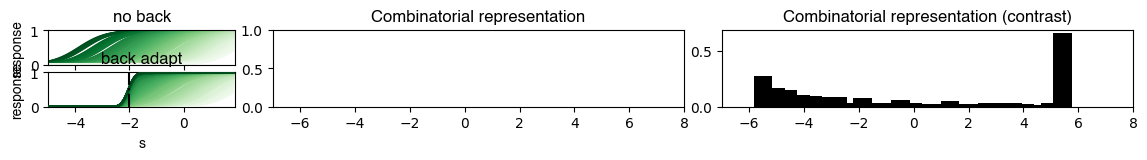

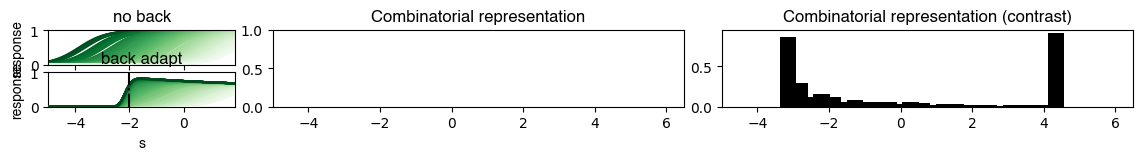

In [9]:
font = {'family': 'helvetica'}
plt.rcParams['pdf.fonttype'] = 'truetype'

    
print(string[par_case])
## ----- Figure parameters ------
markers = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']
color_map_neurons = plt.cm.Greens_r
color_map_pca = plt.cm.turbo#nipy_spectral
norm = Normalize(vmin=0, vmax=5)
norm_contrast = Normalize(vmin=0, vmax=2)
for norm_par in np.array([0, 1]):
    plt.figure(figsize=(14, 1))
    gs = gridspec.GridSpec(2, 5)  # 2 rows, 5 columns grid
    ax1 = plt.subplot(gs[0, 0])  # This subplot spans the first column of the first row
    ax2 = plt.subplot(gs[1, 0])  # This subplot spans the first column of the second row
    ax3 = plt.subplot(gs[:, 1:3])  # This spans all rows and the last two columns
    ax4 = plt.subplot(gs[:, 3:])  # This spans all rows and the last two columns
    ax1.set_title('no back', fontdict=font)
    ax1.set_xlabel('s', fontdict=font)
    ax1.set_ylabel('response', fontdict=font)
    ax1.set_xlim([-5, 1.9])
    ax1.set_ylim([0, 1.02])
    ax2.set_title('back adapt', fontdict=font)
    ax2.set_xlabel('s', fontdict=font)
    ax2.set_ylabel('response', fontdict=font)
    ax2.set_xlim([-5, 1.9])
    ax2.set_ylim([0, 1.02])
    ax3.set_title('Combinatorial representation', fontdict=font)
    ax4.set_title('Combinatorial representation (contrast)', fontdict=font)

    ci_0 = 4
    module_par = 8

    ## ----- Response of the neuronal population ----
    for i_N in range(N):
        r = Adapt_function(s_array, np.sort(alpha_array)[i_N], np.sort(x0_array)[i_N], np.sort(b_array)[i_N]) # Response with non-adapted parameters
        ci = ci_0 + x0_array[i_N]
        ax1.plot(s_array, r, color=color_map_neurons(0.8*norm(ci % module_par)))

    ## ------- Combinatorial response -------

    # Back_array = np.array([1, 0.5, -0.5,-1,-1.5, -2])
    Back_array = np.array([0.5, -0.1, -0.5, -1, -1.5, -2, -2.5, -3, -3.5])
    N_back = Back_array.size
    N_t = 40
    test_array = np.linspace(-3.4, 2, num=N_t)
    # test_array = np.linspace(-4, 5, num=N_t)
    r_test = np.zeros((N_back*N_t + N_t, N))
    r_test_norm = np.zeros((N_back*N_t + N_t, N))
    r_test_n = np.zeros((N_back*N_t + N_t, N))
    r_b_array = np.zeros((s_array.size, N))
    alpha_norm = np.ones(N)

    sigma = 0.2

    for i_back in range(N_back):
        x0_array_a = np.copy(x0_array)
        alpha_array_a = np.copy(alpha_array)
        b_array_a = np.copy(b_array)
        s_back = Back_array[i_back]

        weight = Prob(s_array, sigma, s_back)
        weight = np.cumsum(weight)/np.max(np.cumsum(weight))

        for i_N in range(N):
            idx = np.where(s_array<(s_back + np.random.normal(0, 0.2)))[0]
            r_b = Adapt_function(s_back, alpha_array[i_N], x0_array[i_N], b_array[i_N])
            r_adapt = Adapt_function(s_array, alpha_array_a[i_N], x0_array_a[i_N], b_array_a[i_N])
            r_adapt *= weight 
            r_b_array[:, i_N] = np.copy(r_adapt)

        link_neurons = np.arange(N)
        for i_t in range(N_t):
            val1 = Adapt_function(test_array[i_t], alpha_array.flatten(), x0_array.flatten(), b_array.flatten())
            r_test[i_t, :] = Adapt_function(test_array[i_t], alpha_array.flatten(), x0_array.flatten(), b_array.flatten()) #         if test_array[i_t]<s_back:
            idx_cumsum = np.where(s_array>=test_array[i_t])[0][0]
            val2 = Adapt_function(test_array[i_t], alpha_array.flatten(), x0_array.flatten(), b_array.flatten())*weight[idx_cumsum]           
            r_test[(i_back+1)*N_t + i_t, :] = val2
            r_test_norm[i_t, :] = 2*(val1/(1 + val1 + alpha_norm[link_neurons]*np.mean(r_test[i_t, link_neurons])))
            r_test_norm[(i_back+1)*N_t + i_t, :]= 2*(val2/(1 + val2 + alpha_norm[link_neurons]*np.mean(r_test[(i_back+1)*N_t + i_t, link_neurons])) )

            r_test_n[i_t, :] = np.copy(val2)
            r_test_n[(i_back+1)*N_t + i_t, :] = 2*(val2/(1 + val2 + alpha_norm[link_neurons]*np.mean(r_test[(i_back+1)*N_t + i_t, link_neurons])) )


        if norm_par == 1:  
            ax3.set_xlim([-5, 6.5])
            ax4.set_xlim([-5, 6.5])
            r_test = r_test_norm
            if s_back == -2:
                ax2.axvline(x=-2, color = 'k', linestyle = '-.', zorder = 1000)
                for i_N in range(N):
                    r_a = Adapt_function(s_array, alpha_array[i_N], x0_array[i_N], b_array[i_N])*weight
                    r_a = r_a/(1 + r_a + np.mean(r_b_array[:,link_neurons], axis = 1) )
    #                 idx = np.where(s_array<s_back)[0]
    #                 r_a[idx] = np.zeros(idx.size)
                    ci = ci_0 + x0_array[i_N]
                    ax2.plot(s_array, r_a/0.5, color=color_map_neurons(0.8*norm(ci % module_par)), zorder = 100 - x0_array[i_N])

        else:
            ax3.set_xlim([-7, 8])
            ax4.set_xlim([-7, 8])
            if s_back == -2:
                ax2.axvline(x=-2, color = 'k', linestyle = '-.', zorder = 1000)
                for i_N in range(N):
                    r_a = Adapt_function(s_array, alpha_array[i_N], x0_array[i_N], b_array[i_N])*weight
                    ci = ci_0 + x0_array[i_N]#+ int(np.round(x0_array[i_N]))
                    ax2.plot(s_array, r_a, color=color_map_neurons(0.8*norm(ci % module_par)), zorder = 100 - x0_array[i_N])  

    pca = PCA(n_components=2)
    score = pca.fit_transform(r_test) # Transpose rtest to align samples and features for PCA
    contrast_array = np.zeros((N_back, N_t))

    ci_0 = 11.
    ci_contrast_0 = 0
    module_par = 8
    weight_par = 0.8

    if score.shape[0] > 0:
        ci_contrast_array = np.zeros(( N_back, N_t ))
        counter_back = 0
        for i_back in range(1, N_back+1):
            counter_back += 1

            ci = ci_0 + test_array     
            ci_color = color_map_pca(weight_par*norm(ci % module_par))
            contrast_ = (((test_array + 10) - ( Back_array[i_back-1] + 10))/( Back_array[i_back-1] + 10) )
            ci_contrast = contrast_ + ci_contrast_0
            ci_contrast_color = color_map_pca(weight_par*norm_contrast(ci_contrast % module_par))

            ci_contrast_color[np.where(contrast_<0)[0]] = plt.cm.Greys_r(weight_par*norm_contrast(0)) # OFF-stimuli
            ci_color[np.where(contrast_<0)[0]] = plt.cm.Greys_r(weight_par*norm_contrast(0))
            ci_contrast[np.where(contrast_<0)[0]] = 0 # OFF-stimuli
            ci[np.where(contrast_<0)[0]] = 0

            contrast_array[counter_back-1,:] = weight_par*norm_contrast(ci_contrast %  module_par)

        N_bins = 25
        hist_x, hist_y = np.histogram(score[N_t:, 0], bins=N_bins, density = True)
        dx = hist_y[1] - hist_y[0]
        ax4.bar(hist_y[:-1]+int(dx/2), hist_x, width = 1.5*dx, color = 'k')

    #plt.tight_layout()
    #plt.savefig("Figures/Histogram_PCA_PNs_population_"+str(string_norm[norm_par])+"_sparse.pdf", bbox_inches = 'tight', dpi = 300)
    plt.show()
        